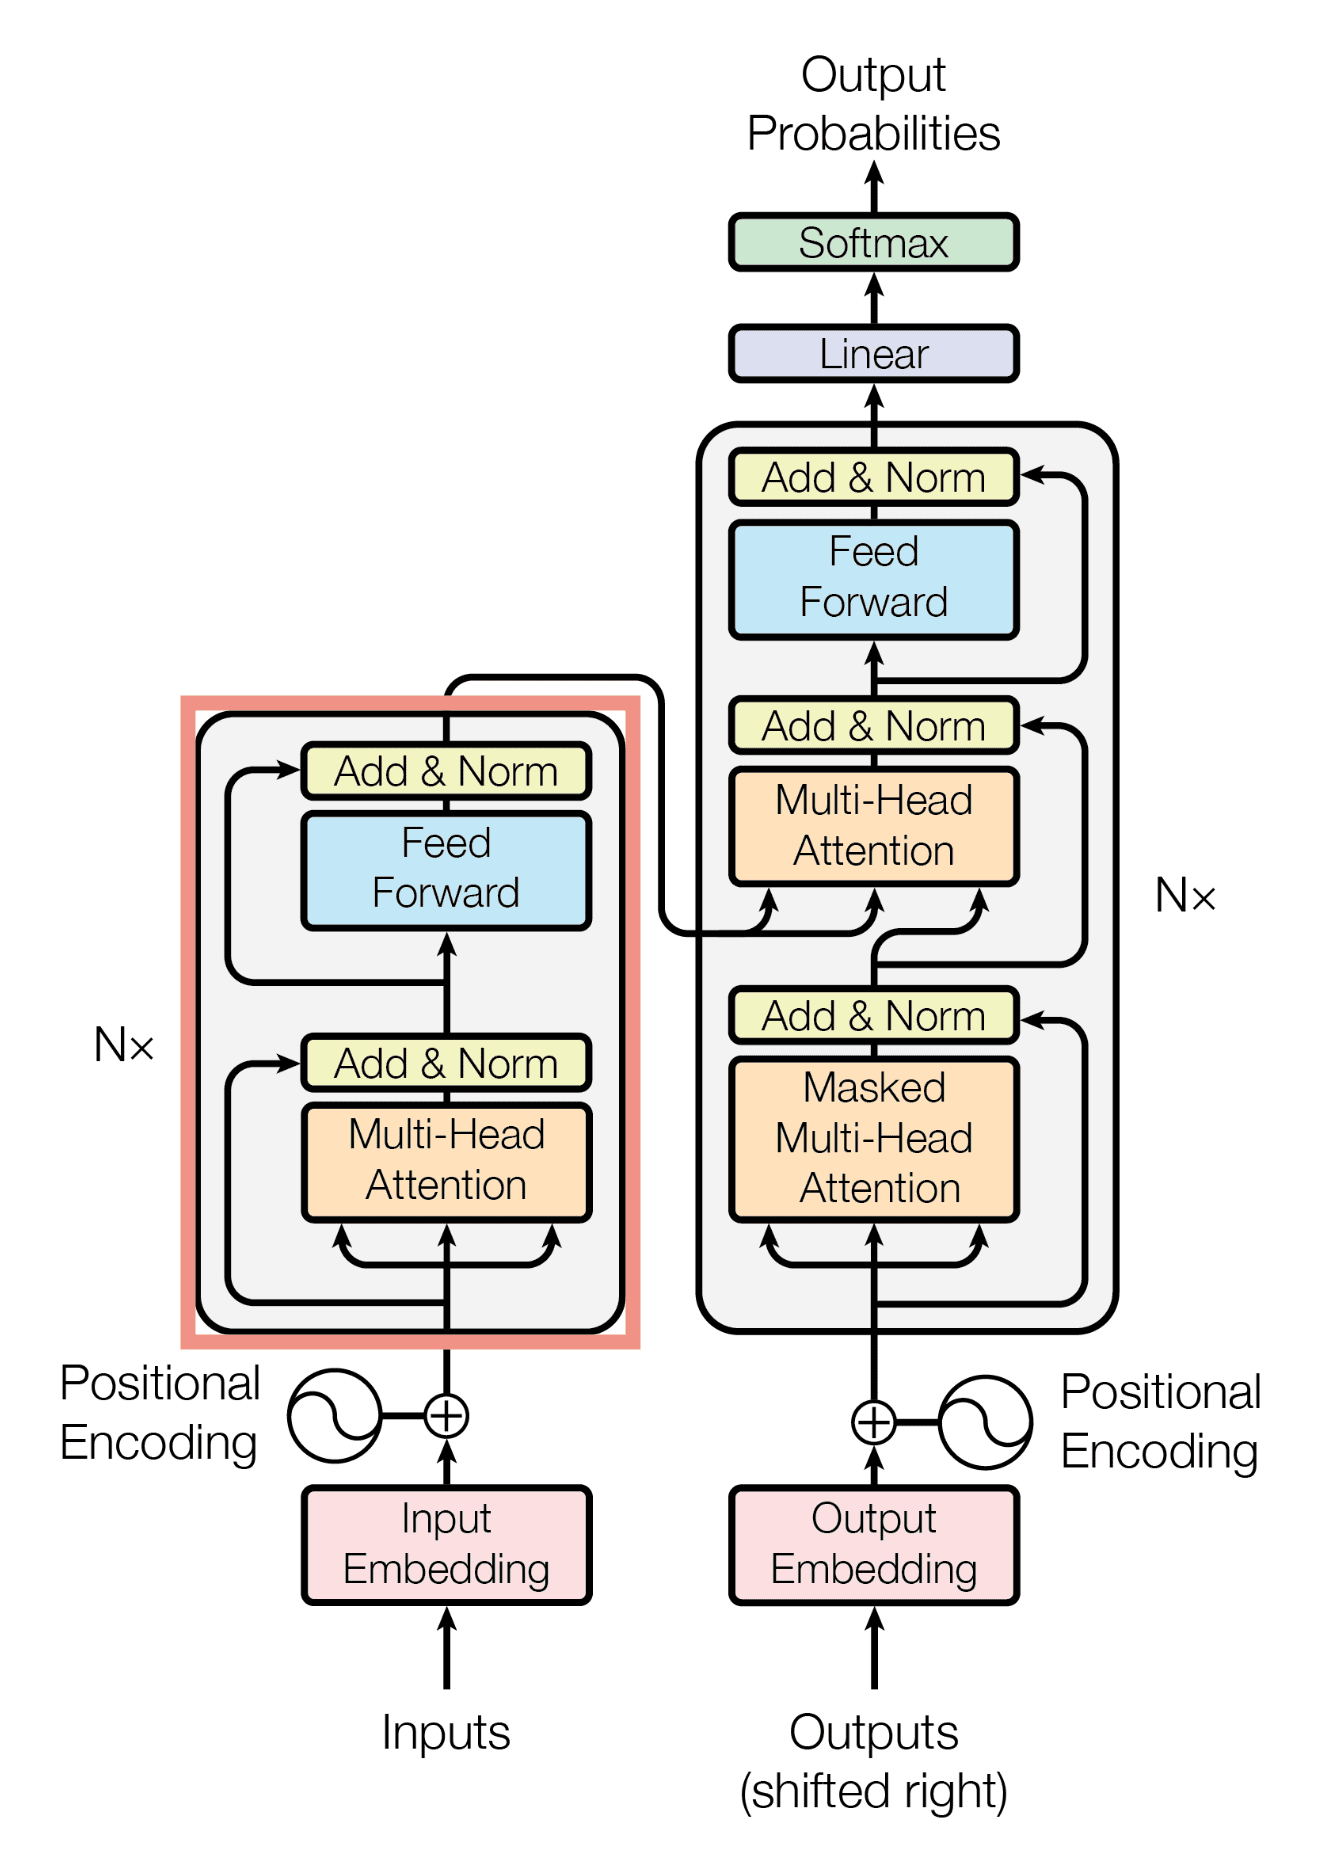

In [1]:
pip install trl transformers peft datasets accelerate

transformers	Core Hugging Face library for models, tokenizers, and pipelines

trl	Fine-tuning tools (SFT, PPO, DPO) for LLMs, built on transformers

peft	Efficient fine-tuning (e.g., LoRA, Prefix Tuning) with minimal GPU usage

datasets	Hugging Face dataset management & preprocessing

accelerate	Simplifies multi-GPU, mixed-precision, and distributed training

In [2]:
pip install bitsandbytes

| Feature                        | Description                                             |
| ------------------------------ | ------------------------------------------------------- |
| **4-bit & 8-bit quantization** | Load large models using a fraction of memory            |
| **NF4 quantization**           | Highly accurate 4-bit quant for LLMs                    |
| **Linear layers replacement**  | Memory-efficient matrix multiplication for transformers |
| **LoRA support**               | Works great with `peft` + `transformers`                |


| Without bitsandbytes                    | With bitsandbytes         |
| --------------------------------------- | ------------------------- |
| FLAN-T5-Large (770M) needs \~2–4GB VRAM | Only \~1–2GB with 8-bit   |
| LLaMA-7B needs \~32GB VRAM              | Only \~6–8GB with 4-bit   |
| Slower inference                        | Faster + memory-efficient |


In [3]:
import json
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments
)
from trl import SFTTrainer
from peft import LoraConfig, prepare_model_for_kbit_training

In [5]:
from transformers import AutoModelForSeq2SeqLM

Model	Params	Quantized (bnb)	Good For	HuggingFace Model Name
google/flan-t5-small	80M	 (fp16/bnb)	QA, code, translation	"google/flan-t5-small"

tiiuae/falcon-rw-1b	1.3B	(bnb 4-bit)	Text generation	"tiiuae/falcon-rw-1b"

mistralai/Mistral-7B-Instruct-v0.2	7B	 (bnb 4-bit)	Strong generation, instructions	"mistralai/Mistral-7B-Instruct-v0.2"

microsoft/phi-2	2.7B		Code + Reasoning	"microsoft/phi-2"

HuggingFaceH4/zephyr-7b-alpha	7B		Chat-based QA	"HuggingFaceH4/zephyr-7b-alpha"

In [14]:
model_name = "google/flan-t5-small"

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token

In [18]:
# # Load model with 4-bit quantization
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     device_map="auto",
#     quantization_config=bnb_config,
#     trust_remote_code=True
# )

In [38]:
import torch

In [43]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
)

| Argument                    | Meaning                                 |
| --------------------------- | --------------------------------------- |
| `load_in_4bit`              | Load model with 4-bit quant             |
| `bnb_4bit_compute_dtype`    | Use `torch.float16` or `torch.bfloat16` |
| `bnb_4bit_use_double_quant` | Helps reduce error in quantization      |
| `bnb_4bit_quant_type`       | `"nf4"` or `"fp4"` (NF4 is better)      |


In [74]:
from datasets import load_dataset

In [78]:
{"prompt": "What is Artificial Intelligence?", "completion": "Artificial Intelligence is the simulation of human intelligence processes by machines, especially computer systems."}
{"prompt": "Explain the process of photosynthesis.", "completion": "Photosynthesis is the process by which green plants use sunlight to synthesize food from carbon dioxide and water."}
{"prompt": "What is Newton's first law of motion?", "completion": "Newton's first law states that an object will remain at rest or in uniform motion in a straight line unless acted upon by an external force."}
{"prompt": "Who wrote 'Romeo and Juliet'?", "completion": "William Shakespeare wrote 'Romeo and Juliet'."}
{"prompt": "Translate to French: 'Good morning!'", "completion": "Bonjour!"}
{"prompt": "What is the capital of France?", "completion": "The capital of France is Paris."}
{"prompt": "Solve: 5 + 7", "completion": "5 + 7 = 12"}
{"prompt": "Define machine learning.", "completion": "Machine learning is a field of computer science that gives computers the ability to learn without being explicitly programmed."}
{"prompt": "Summarize the water cycle.", "completion": "The water cycle includes evaporation, condensation, precipitation, and collection."}
{"prompt": "What is the chemical symbol for gold?", "completion": "The chemical symbol for gold is Au."}
{"prompt": "What is the function of roots in a plant?", "completion": "Roots anchor the plant in the ground and absorb water and nutrients from the soil."}
{"prompt": "What are the three states of matter?", "completion": "The three states of matter are solid, liquid, and gas."}
{"prompt": "Why do we see lightning before we hear thunder?", "completion": "Because light travels faster than sound, we see lightning before we hear thunder."}
{"prompt": "Name the five sense organs.", "completion": "The five sense organs are eyes, ears, nose, tongue, and skin."}
{"prompt": "What is evaporation?", "completion": "Evaporation is the process by which water changes into vapor on heating."}
{"prompt": "Why is the Sun important for Earth?", "completion": "The Sun provides light and heat, which are essential for life on Earth."}
{"prompt": "What are herbivores?", "completion": "Herbivores are animals that eat only plants."}
{"prompt": "How do plants make their food?", "completion": "Plants make their food through a process called photosynthesis using sunlight, carbon dioxide, and water."}
{"prompt": "What is air made up of?", "completion": "Air is a mixture of gases including oxygen, nitrogen, carbon dioxide, and others."}
{"prompt": "What is a habitat?", "completion": "A habitat is a natural environment where an organism lives and grows."}



{'prompt': 'What is a habitat?',
 'completion': 'A habitat is a natural environment where an organism lives and grows.'}

In [77]:
dataset = load_dataset("json", data_files="dataset.jsonl", split="train")
dataset = dataset.train_test_split(test_size=0.1)

Generating train split: 0 examples [00:00, ? examples/s]

In [80]:
# === LoRA Config ===
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"  # for Flan-T5
)

| Parameter      | Value            | Explanation                                                                                                                                   |
| -------------- | ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| `r`            | `8`              | The **rank** of the LoRA matrices (A and B). This controls adapter size. Lower = smaller adapters, higher = more capacity.                    |
| `lora_alpha`   | `16`             | A scaling factor. Final adapter weight is scaled by `alpha / r`. Here, `16 / 8 = 2`. Helps stabilize training.                                |
| `lora_dropout` | `0.1`            | Dropout applied to the adapter input (to avoid overfitting).                                                                                  |
| `bias`         | `"none"`         | Specifies whether to add bias. `"none"` means **only LoRA adapters are trained**, biases are untouched. Can also be `"all"` or `"lora_only"`. |
| `task_type`    | `"SEQ_2_SEQ_LM"` | Specifies the model type. Use this for T5/FLAN/encoder-decoder models. For decoder-only models (GPT, LLaMA), use `"CAUSAL_LM"`.               |


In [82]:
from trl import SFTTrainer, SFTConfig

In [98]:
# === Trainer Config ===
training_args = SFTConfig(

    output_dir="./flan-t5-lora-sft",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="epoch",

    bf16=False,                  # or use fp16=True if available
    packing=False,               # must be False when using prompt/completion
    completion_only_loss=True,   # important
    report_to=[]
)

| Parameter                     | Value                  | Explanation                                                                                           |
| ----------------------------- | ---------------------- | ----------------------------------------------------------------------------------------------------- |
| `output_dir`                  | `"./flan-t5-lora-sft"` | Where checkpoints, logs, and configs are saved.                                                       |
| `per_device_train_batch_size` | `4`                    | Batch size **per GPU**. Effective batch size = `batch_size × gradient_accumulation_steps × num_GPUs`. |
| `gradient_accumulation_steps` | `2`                    | Backpropagation is done every 2 steps to simulate larger batch size (helps when low VRAM).            |
| `learning_rate`               | `5e-5`                 | Starting learning rate. Common range for LoRA is `1e-4` to `5e-5`.                                    |
| `num_train_epochs`            | `3`                    | Number of training passes through the dataset.                                                        |
| `logging_steps`               | `10`                   | How often to log training loss & metrics (in steps).                                                  |
| `save_strategy`               | `"epoch"`              | Save a checkpoint after each epoch.                                                                   |


| Parameter                                                         | Explanation                                                                                               |
| ----------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| `bf16=False`                                                      | Use **bfloat16** for faster training and less memory, if supported by your GPU. If not, leave as `False`. |
| `fp16=True`                                                       | Alternatively, you can use `fp16=True` (useful on older GPUs).                                            |
|  **Use only one**: either `fp16=True` or `bf16=True` — not both. |                                                                                                           |


| Parameter                   | Explanation                                                                                                                                                  |
| --------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `packing=False`             | Leave this `False` when you're using **prompt + completion** format. If you were doing multi-prompt packing (for OpenAI-style chat), you could turn this on. |
| `completion_only_loss=True` | Very important. Ensures **only the completion part** of the sequence is used for computing loss. The prompt is ignored during loss calculation.              |


SFTTrainer for supervised fine-tuning of your LoRA-adapted Flan-T5 model.

In [99]:
# === Train ===
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
     peft_config=lora_config,

)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


| Parameter                        | What it does                                                                                                                |
| -------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| `model=model`                    | This is your base model (e.g., `Flan-T5`) optionally wrapped with `get_peft_model(...)` for LoRA.                           |
| `args=training_args`             | Configuration for training: batch size, learning rate, epochs, precision, etc. This is your `SFTConfig` object from before. |
| `train_dataset=dataset["train"]` | The training split of your dataset, typically a `datasets.Dataset` object.                                                  |
| `eval_dataset=dataset["test"]`   | The evaluation (validation) split of your dataset. Used for computing eval metrics (loss, accuracy, etc.).                  |
| `peft_config=lora_config`        | The LoRA configuration object (e.g., from `LoraConfig(...)`) which tells the trainer to apply LoRA fine-tuning.             |


In [100]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


TrainOutput(global_step=9, training_loss=0.0, metrics={'train_runtime': 5.9268, 'train_samples_per_second': 9.111, 'train_steps_per_second': 1.519, 'total_flos': 660888514560.0, 'train_loss': 0.0})

In [101]:
trainer.model.save_pretrained("finetuned-flan-lora")
tokenizer.save_pretrained("finetuned-flan-lora")

('finetuned-flan-lora/tokenizer_config.json',
 'finetuned-flan-lora/special_tokens_map.json',
 'finetuned-flan-lora/spiece.model',
 'finetuned-flan-lora/added_tokens.json',
 'finetuned-flan-lora/tokenizer.json')

In [102]:
# Load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("finetuned-flan-lora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("finetuned-flan-lora")

In [103]:
def generate_response(prompt: str):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=50)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [104]:
print(generate_response("What is the capital of Germany?"))

berlin


In [106]:
print(generate_response("Solve: 5 + 7"))

-2


In [105]:
print(generate_response("How do plants make their food?"))

Using a sand paper towel, plant the seeds of the plant.


In [107]:
pip install transformers datasets evaluate sacrebleu rouge_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0827f2ee1979d697449bf5b39bdfccd1695a03be6f95afa18c3fa6aa9db1b121
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [109]:
import evaluate

rouge = evaluate.load("rouge")
bleu = evaluate.load("sacrebleu")


In [117]:
import numpy as np

In [111]:
pip install evaluate
